# Importa as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
import scipy.sparse as sps
import clisops.core as clore
import clisops as cl

In [2]:
import gcsfs
import intake
import xarray as xr
import xesmf as xe
import numpy as np

In [3]:
#Acessa os dados em nuvem
cmip6 = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [285]:
#Realiza a pesquisa
pesquisa = dict(source_id = 'IPSL-CM6A-LR',
                table_id = 'Omon',
                variable_id = 'tos',
                experiment_id='historical',
                member_id = "r1i1p1f1")

In [348]:
#Passos para acessar os dados referetens a pesquisa
cmip6_ipsl_tos = cmip6.search(require_all_on=['source_id'], **pesquisa) 

In [287]:
#Verifica se veio o activity_id CMIP
cmip6_ipsl_tos.df.activity_id.unique()

array(['CMIP'], dtype=object)

In [288]:
#Faz o dowload dos arquivos
cmip6_dsets = cmip6_ipsl_tos.to_dataset_dict(aggregate=True,
                                           storage_options={'token': 'anon'},
                                           zarr_kwargs={'consolidated': True,
                                                        'decode_times': True,
                                                        'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [289]:
#Encontra o nome "chave" dos arquivos no dowload que foi realizado
cmip6_dsets.keys()

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'])

In [349]:
#Coloca esses dados em uma variável
ipsl_tos = cmip6_dsets["CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn"].squeeze()

In [329]:
ipsl_tos

<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, time: 1980, x: 362, y: 332)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id       <U8 'r1i1p1f1'
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:        cv=6.2.3.5-2-g63b123e
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   historical
    NCO:                     "4.6.0"
    activity_id:             CMIP
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-11-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    version_id:              v20180803
    intake_esm_varname:      ['tos']
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn

In [330]:
ipsl_tos = ipsl_tos.drop(["time_bounds", "member_id"])

In [331]:
ipsl_tos_halo = ipsl_tos
ipsl_tos_nohalo = ipsl_tos.isel(x = slice(1, 361))

In [163]:
def plot_curv_grid(ds, var="tos"):    
        lat=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
        lon=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]        
        if any([i==None for i in [lat, lon]]): 
            print(ds.attrs["source_id"],": Cannot identify latitude/longitude.")
            return
        plt.figure(figsize=(16, 9), dpi=120)
        plt.scatter(x=ds[lon], y=ds[lat], s=0.01)
      
        

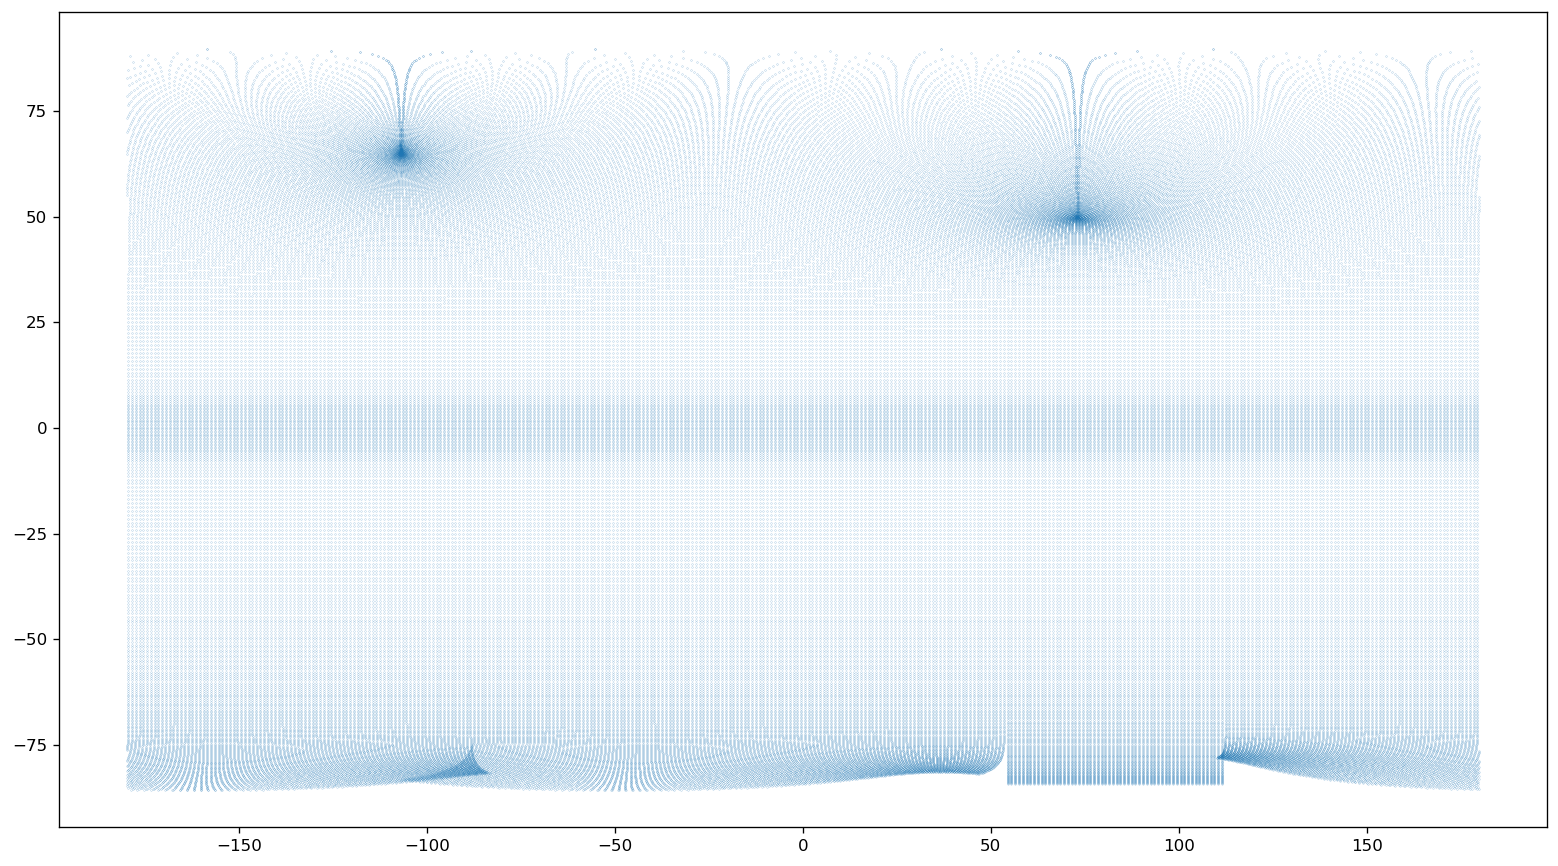

In [225]:
plot_curv_grid(ipsl_tos_nohalo)

In [341]:
#create the regridder
ds_out = xe.util.grid_global(1, 1)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [317]:
# Function to set the contribution of certain source grid cells to 0
def add_zeros_to_weights(weights, zero_mask):
    """Add zeros to the regridding weights sparse matrix according to the specified source mask.

    Parameters
    ----------
    weights : scipy.sparse.coo_matrix
      Sparse weights matrix.
    zero_mask: 2D numpy.array
      Array with values != 0, where to set weight contributions to 0      

    Returns
    -------
    weights : scipy.sparse.coo_matrix
      Sparse weights matrix.
    """
    
    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    M = weights.tolil()
    tozero=np.where(zero_mask.ravel()!=0)  # Get indices where to set weight matrix to 0
    M[:,tozero]=0  # Set weight matrix entries to 0
    return sps.coo_matrix(M)

In [319]:
# Masks for add_zeroes_to_weights
mask_ipsl = np.zeros_like(ipsl_tos_halo.nav_lat)
mask_ipsl[:,[0,-1]] = 1

# Masks for the xesmf.Regridder input
mask_ipsl_regridder = np.ones_like(ipsl_tos_halo.nav_lat, dtype=bool)
mask_ipsl_regridder[:,[0,-1]] = False

# Set up datasets with masks
ipsl_tos_halo_mask = ipsl_tos_halo.copy()
ipsl_tos_halo_mask['mask'] = xr.DataArray(data=mask_ipsl_regridder, dims=("y", "x"))


## Generate the weights

In [355]:
# Regridding methods
method_list = ['nearest_s2d', 'patch', "bilinear"]

# Function to generate the weights
#   If grids have problems of degenerated cells near the poles there is the ignore_degenerate option
def regrid(ds_in, ds_out, method, periodic, ignore_degenerate=None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic=periodic, 
                        ignore_degenerate=ignore_degenerate) #unmapped_to_nan=True) 

In [ ]:
# Generating the weights for all specified methods
regridder_ipsl_tos_halo={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_ipsl_tos_halo[method]=regrid(ipsl_tos_halo, \
                                                 ds_out, method, \
                                                 periodic=True, \
                                                 ignore_degenerate=True)

## Create the weights with masked halo

In [ ]:
# Generating the weights for all specified methods
regridder_ipsl_tos_halo_mask={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_ipsl_tos_halo_mask[method]=regrid(ipsl_tos_halo_mask, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

## Create the weights and set weight matrix entries of halo cells to 0


In [356]:
regridder_ipsl_tos_halo_zero={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_ipsl_tos_halo_zero[method]=regrid(ipsl_tos_halo, \
                                                      ds_out, method, \
                                                      periodic=True, \
                                                      ignore_degenerate=True)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 875 ms, sys: 44.4 ms, total: 919 ms
Wall time: 980 ms
-------------
MPI-ESM-1-2-LR patch
CPU times: user 1min 6s, sys: 1.13 s, total: 1min 7s
Wall time: 1min 8s
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 6.79 s, sys: 477 ms, total: 7.26 s
Wall time: 7.38 s


In [357]:
for method in method_list:
    regridder_ipsl_tos_halo_zero[method].weights = add_zeros_to_weights(
        regridder_ipsl_tos_halo_zero[method].weights, 
        mask_ipsl
    )
    regridder_ipsl_tos_halo_zero[method].weights = xe.smm.add_nans_to_weights(
        regridder_ipsl_tos_halo_zero[method].weights
    )


## Create the weights without the halo


In [359]:
# Generating the weights for all specified methods
regridder_ipsl_tos={}
for method in method_list:
    print("-------------\nMPI-ESM-1-2-LR", method)
    %time regridder_ipsl_tos[method]=regrid(ipsl_tos, \
                                            ds_out, method, \
                                            periodic=True, \
                                            ignore_degenerate=True)

-------------
MPI-ESM-1-2-LR nearest_s2d
CPU times: user 918 ms, sys: 46.5 ms, total: 964 ms
Wall time: 981 ms
-------------
MPI-ESM-1-2-LR patch
CPU times: user 1min 4s, sys: 1.23 s, total: 1min 6s
Wall time: 1min 6s
-------------
MPI-ESM-1-2-LR bilinear
CPU times: user 6.86 s, sys: 414 ms, total: 7.28 s
Wall time: 7.37 s


## Regrid

In [362]:
for method in method_list:
    ds_out["tos_ipsl_halo_mask_"+method]=regridder_ipsl_tos_halo_mask[method](ipsl_tos_halo_mask.tos)
    ds_out["tos_ipsl_halo_zero_"+method]=regridder_ipsl_tos_halo_zero[method](ipsl_tos_halo.tos)
    ds_out["tos_ipsl_halo_"+method]=regridder_ipsl_tos_halo[method](ipsl_tos_halo.tos)
    ds_out["tos_ipsl_"+method]=regridder_ipsl_tos[method](ipsl_tos.tos)
    ds_out["tos_ipsl_"+method]=regridder_ipsl_tos[method](ipsl_tos.tos)   

/opt/conda/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/conda/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/conda/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/conda/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/conda/lib/python3.8/site-packages/xesmf/fro

In [368]:
ds_out

<xarray.Dataset>
Dimensions:                         (time: 1980, x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon                             (y, x) float64 -179.5 -178.5 ... 178.5 179.5
    lat                             (y, x) float64 -89.5 -89.5 ... 89.5 89.5
    lon_b                           (y_b, x_b) int64 -180 -179 -178 ... 179 180
    lat_b                           (y_b, x_b) int64 -90 -90 -90 ... 90 90 90
  * time                            (time) object 1850-01-16 12:00:00 ... 201...
    member_id                       <U8 'r1i1p1f1'
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    tos_ipsl_halo_mask_nearest_s2d  (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_zero_nearest_s2d  (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_nearest_s2d       (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_nearest_s2d            (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_mask_patch        (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_zero_patch        (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_patch             (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_patch                  (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_mask_bilinear     (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_zero_bilinear     (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_halo_bilinear          (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>
    tos_ipsl_bilinear               (time, y, x) float64 dask.array<chunksize=(252, 180, 360), meta=np.ndarray>

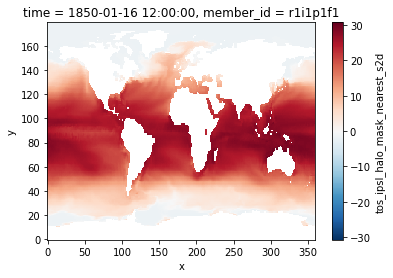

In [385]:
a = ds_out["tos_ipsl_halo_mask_nearest_s2d"].isel(time=0).plot()
a

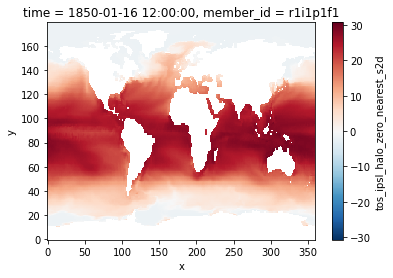

In [386]:
b = ds_out["tos_ipsl_halo_zero_nearest_s2d"].isel(time=0).plot()
b

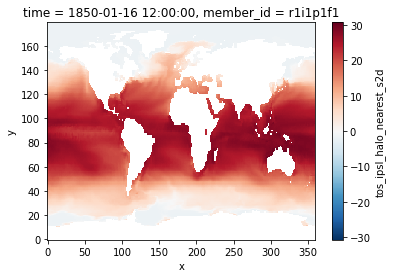

In [387]:
c = ds_out["tos_ipsl_halo_nearest_s2d"].isel(time=0).plot()
c

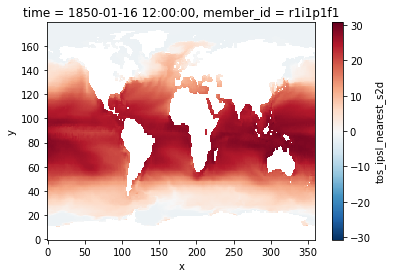

In [388]:
d = ds_out["tos_ipsl_nearest_s2d"].isel(time=0).plot()
d

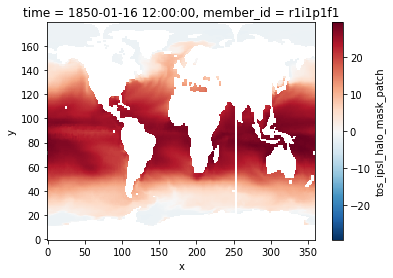

In [389]:
e = ds_out["tos_ipsl_halo_mask_patch"].isel(time=0).plot()
e

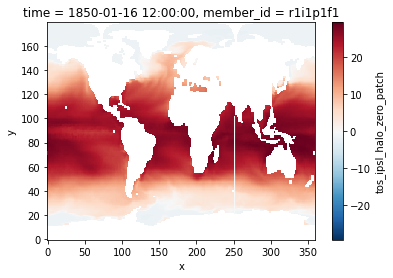

In [390]:
f = ds_out["tos_ipsl_halo_zero_patch"].isel(time=0).plot()
f

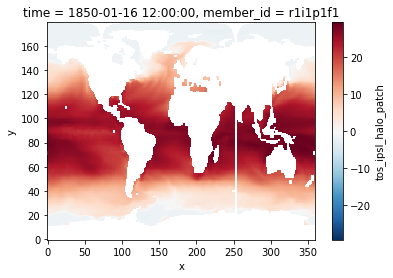

In [391]:
g = ds_out["tos_ipsl_halo_patch"].isel(time=0).plot()
g

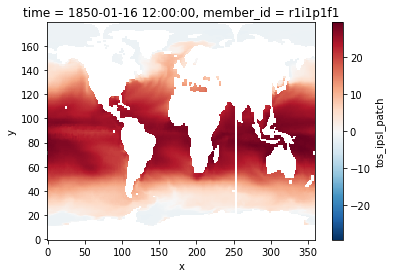

In [392]:
h = ds_out["tos_ipsl_patch"].isel(time=0).plot()
h

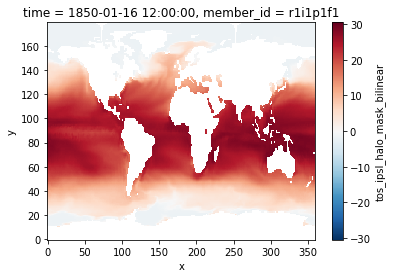

In [393]:
i = ds_out["tos_ipsl_halo_mask_bilinear"].isel(time=0).plot()
i

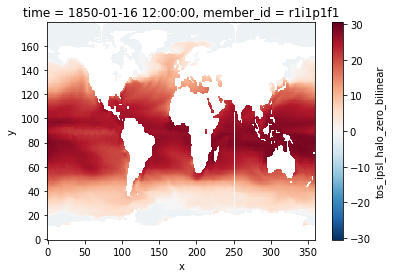

In [394]:
j = ds_out["tos_ipsl_halo_zero_bilinear"].isel(time=0).plot()
j

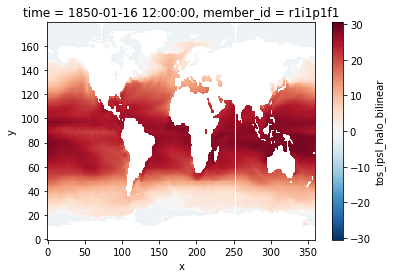

In [395]:
k = ds_out["tos_ipsl_halo_bilinear"].isel(time=0).plot()
k

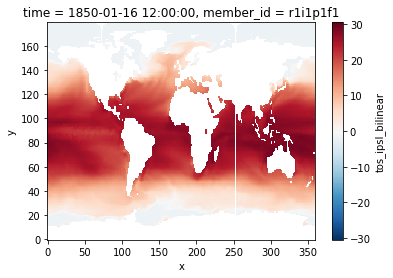

In [396]:
l = ds_out["tos_ipsl_bilinear"].isel(time=0).plot()
l